<hr />
<h1 align="center">Using ArcticDB for equity options data: a worked example</h1>
<left><img src="https://raw.githubusercontent.com/man-group/ArcticDB/master/static/ArcticDBCropped.png" alt="ArcticDB Logo" width="400">
<hr />
<h2>A Sample Workflow for Equity Options</h2>

In this notebook we will:
* Download (from github) a set of market data for options on a group of tech stocks
* Store the data in ArcticDB using an incremental timeseries update workflow
* Create a range of useful option queries
* Use the queries to drive an interactive chart

<hr />
<h2>Thank you to optiondata.org</h2>

We would like to express our gratitude to [optiondata.org](https://optiondata.org/) for giving us permission to use a small slice of their free data in this demo.

This data is free and available on their website for you to download yourself.
<hr />


### Installs and Imports

In [2]:
!pip install arcticdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 16.0 MB/s eta 0:00:00


In [3]:
%matplotlib inline
import arcticdb as adb
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import ipywidgets as widgets
import functools

### Parameters for the Notebook

In [4]:
branch = 'master'
all_dates = ['2013-06-03', '2013-06-10', '2013-06-17', '2013-06-24']
sym = 'tech_options'
delta_low = 0.05
delta_high = 0.55

### ArcticDB Setup

In [5]:
arctic = adb.Arctic("lmdb://arcticdb_equity_options")
lib = arctic.get_library('demo_options', create_if_missing=True)

### Functions for Reading Github and ArcticDB Queries

In [6]:
def gitub_url(as_of, branch):
    return f"https://raw.githubusercontent.com/man-group/ArcticDB/{branch}/docs/mkdocs/docs/notebooks/data/{as_of}tech-options.csv"

# read the csv from github
def read_github_options_file(as_of, branch='master'):
    try:
        raw_df = pd.read_csv(gitub_url(as_of, branch))
    except Exception as e:
        raise Exception(f"Github access error: {e}")
    return raw_df.set_index(pd.DatetimeIndex(raw_df['quote_date'])).drop(columns=['Unnamed: 0'])

# query to get option expiries for a date and underlying
def options_expiries_query(as_of, underlying):
    q = adb.QueryBuilder()
    filter = (q['underlying'] == underlying) & (q['expiration'] != as_of)
    q = q[filter].groupby('expiration').agg({'volume': 'sum'})
    return q

def read_expiries(sym, as_of, underlying):
    read_date = pd.Timestamp(as_of)
    return lib.read(sym, date_range=(read_date, read_date),
                    query_builder=options_expiries_query(as_of, underlying)
                    ).data.sort_index().index.values

# query to read all underlyings
def options_all_underlyings_query():
    q = adb.QueryBuilder()
    q = q.groupby('underlying').agg({'volume': 'sum'})
    return q

def read_all_underlyings(sym):
    return lib.read(sym,
                    query_builder=options_all_underlyings_query()
                    ).data.sort_index().index.values

# query to get all options for an underlying and expiry. date filter uses date_range in the read
def options_curve_single_expiry_query(underlying, expiry):
    q = adb.QueryBuilder()
    filter = (q['underlying'] == underlying) & (q['expiration'] == expiry)
    return q[filter]

# query to get all options for an underlying and expiry with delta in a specified interval
# calls have delta >= 0, puts have delta <= 0
def options_curve_single_expiry_delta_bracket_query(underlying, expiry, delta_low, delta_high):
    q = adb.QueryBuilder()
    filter = ((q['underlying'] == underlying) & (q['expiration'] == expiry) &
              (((q['delta'] >= delta_low) & (q['delta'] <= delta_high)) |
               ((q['delta'] >= -delta_high) & (q['delta'] <= -delta_low))
              )
             )
    return q[filter].groupby('strike').agg({'implied_volatility': 'mean'})

def read_vol_curve_single_expiry(sym, as_of, underlying, expiry):
    read_date = pd.Timestamp(as_of)
    return lib.read(sym, date_range=(read_date, read_date), query_builder=options_curve_single_expiry_query(underlying, expiry)).data

@functools.cache
def read_vol_curve_single_expiry_exclude_itm_otm(sym, as_of, underlying, expiry, delta_low, delta_high):
    read_date = pd.Timestamp(as_of)
    q = options_curve_single_expiry_delta_bracket_query(underlying, expiry, delta_low, delta_high)
    vol_curve_raw = lib.read(sym, date_range=(read_date, read_date), query_builder=q).data
    return vol_curve_raw.sort_index()*100

### Read Data from Github and Store in ArcticDB

In [7]:
# writes (and creates) the symbol for the first date, then updates for subsequent dates
create_sym = True
for d in all_dates:
    df = read_github_options_file(d, branch)
    print(f"Date: {d} - saved {len(df)} records")
    arctic_fn = lib.write if create_sym else lib.update
    arctic_fn(sym, df)
    create_sym = False

Date: 2013-06-03 - saved 6792 records
Date: 2013-06-10 - saved 6622 records
Date: 2013-06-17 - saved 6442 records
Date: 2013-06-24 - saved 6134 records


In [8]:
all_uly = read_all_underlyings(sym)
all_uly

array(['AAPL', 'ADBE', 'AMZN', 'ASML', 'CSCO', 'IBM', 'MSFT', 'NVDA',
       'ORCL', 'TSLA', 'TSM'], dtype=object)

### Functions for Creating the Charts and Simple Interactive Controls

In [9]:
def create_vol_curve_chart_single(ax, sym, as_of, uly, delta_low, delta_high):
    exp = read_expiries(sym, as_of, uly)
    cmap = plt.get_cmap('rainbow', len(exp))
    format_kw = {'linewidth': 2, 'alpha': 0.85}
    for i, e in enumerate(exp):
        vol_curve = read_vol_curve_single_expiry_exclude_itm_otm(sym, as_of, uly, e, delta_low, delta_high)
        vol_curve.plot(ax=ax, y='implied_volatility', label=e, grid=True, color=cmap(i), **format_kw)
    ax.set_title(f"Option Volatility Curves for {uly}, as of {as_of}")
    ax.set_ylabel("implied volatility")
    ax.legend(loc='upper right', framealpha=0.7)
    ax.set_facecolor('whitesmoke')

def create_vol_curve_chart(sym, as_of1, uly1, as_of2, uly2, delta_low, delta_high):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    create_vol_curve_chart_single(ax1, sym, as_of1, uly1, delta_low, delta_high)
    create_vol_curve_chart_single(ax2, sym, as_of2, uly2, delta_low, delta_high)

class input_widgets(object):
    def __init__(self):
        self.container = widgets.VBox()
        self.create_widgets()
        self.redraw_chart()

    @property
    def as_of1(self):
        return self.container.children[0].children[0].value

    @property
    def uly1(self):
        return self.container.children[0].children[1].value

    @property
    def as_of2(self):
        return self.container.children[1].children[0].value

    @property
    def uly2(self):
        return self.container.children[1].children[1].value

    @property
    def out(self):
        return self.container.children[2]

    def create_widgets(self):
        self.as_of1_dd = widgets.Dropdown(
            options=all_dates,
            value=all_dates[0],
            description='Date1:',
            disabled=False,
        )
        self.as_of1_dd.observe(self._on_change, ['value'])

        self.as_of2_dd = widgets.Dropdown(
            options=all_dates,
            value=all_dates[0],
            description='Date2:',
            disabled=False,
        )
        self.as_of2_dd.observe(self._on_change, ['value'])

        self.uly1_dd = widgets.Dropdown(
            options=all_uly,
            value=all_uly[0],
            description='Underlying1:',
            disabled=False,
        )
        self.uly1_dd.observe(self._on_change, ['value'])

        self.uly2_dd = widgets.Dropdown(
            options=all_uly,
            value=all_uly[1],
            description='Underlying2:',
            disabled=False,
        )
        self.uly2_dd.observe(self._on_change, ['value'])

        self.output_widget = widgets.Output(layout=widgets.Layout(height='900px'))

        self.container.children = [
            widgets.HBox([self.as_of1_dd, self.uly1_dd]),
            widgets.HBox([self.as_of2_dd, self.uly2_dd]),
            self.output_widget
        ]

    def _on_change(self, _):
        self.redraw_chart()

    def redraw_chart(self):
        with self.output_widget:
            self.output_widget.clear_output(wait=True)
            create_vol_curve_chart(sym, self.as_of1, self.uly1, self.as_of2, self.uly2, delta_low, delta_high)
            plt.show()

### Interactive Vol Curves for Side By Side Viewing of 2 Dates/Stocks
* Click the dropdowns and the charts will update
* The data is read from ArcticDB as part of the chart creation

In [10]:
w = input_widgets()
w.container

For the preview, the chart and widgets will look like this image

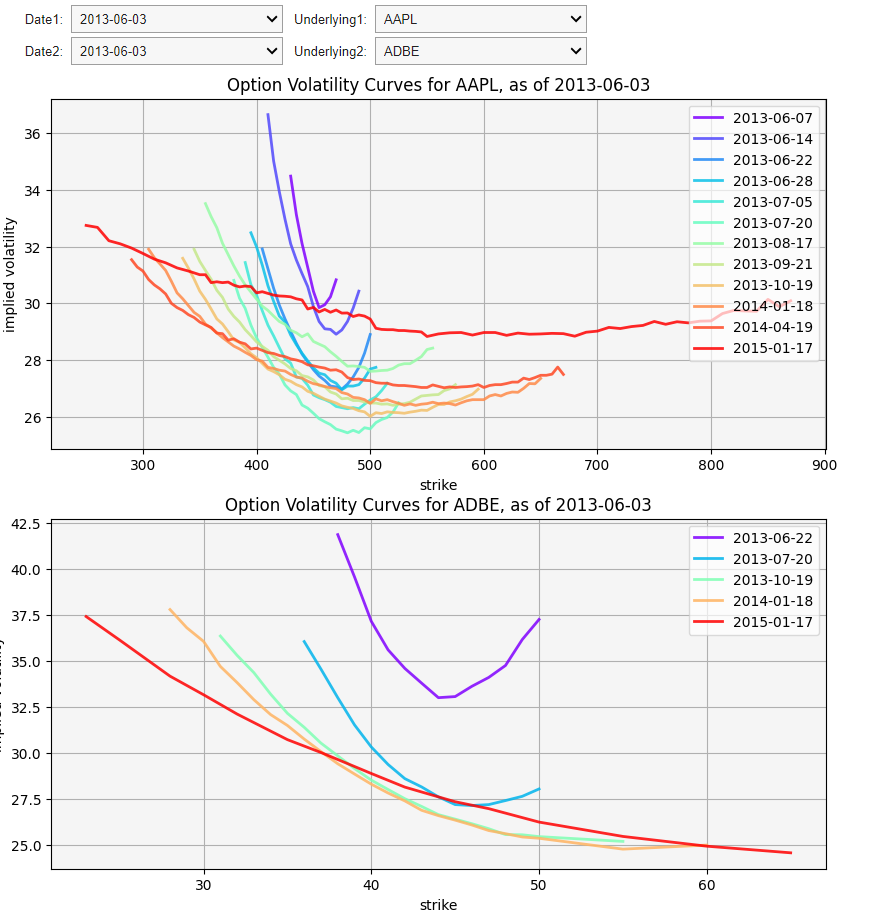

## Conclusions

* We have demonstrated a simple data pipeline for capture and storage of options data
* We created a useful series of queries on the data
* These queries are used to build interactive charts
* The result is a simple visual browser for option volatility curves
* In a real system, the data collection and storage would probably be a separate process from the visualisation
* The simplicity and flexibility of ArcticDB made the data handling the easy part, compared to getting the charts and interactive widgets looking nice